# Installing libraries

In [1]:
!conda install polars -y -q

Channels:
 - conda-forge
 - nvidia
 - pytorch
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.



# Importing required libraries

In [2]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

# Helper functions and variables

In [3]:
def get_association_count(df,threshold, use_func = None):
    count = 0
    if not use_func:
        for i,j in df.count().to_dict(as_series=False).items():
            if i!='PATIENT_NUM' and j[0]>threshold:
                count+=1
    elif use_func == 'sum':
        for i,j in df.sum().to_dict(as_series=False).items():
            if i!='PATIENT_NUM' and j[0]>threshold:
                count+=1
    return count

In [4]:
def get_patients_association_threshold_bar_plot(threshold, patients_association_count,title = None):
    bplot = plt.bar(list(map(str, threshold)) , patients_association_count)
    plt.bar_label(bplot,
                  fontweight='bold',
                  color='green')
    if title:
        plt.title('Patients assocation count for labloincs against threshold')
    else:
        plt.title('Patients assocation count vs threshold')
            
    plt.xlabel('Threshold')
    plt.ylabel('Patient Count')
    plt.show()

# Config class for file paths and other configurations

In [77]:
class modeling_config:
    labs_path = 'Determine_lab_results_median_domain_expert_pivot.parquet'
    meds_path = 'Determine_medications_active_ingredients_pivot.parquet'
    diag_path = 'Determine_diagnoses_initial_3_chars_with_icd10z.parquet'
    
    demo_path = 'Determine_modeling_demographics_data.parquet'
    target_path = 'Determine_Cohort_with_labels_OutcomeDate.parquet'
    association_threshold = 20
    folder = './Determine_Cohort_files_pivot/'

# EDA & Final processing for modeling

## Lab results

In [78]:
labresults_df = pl.read_parquet(modeling_config.folder+modeling_config.labs_path)

In [79]:
print("Number of data points: ",len(labresults_df))

Number of data points:  406273


In [80]:
labresults_df.head(3)

PATIENT_NUM,LOINC:2500-7,LOINC:5818-0,LOINC:2571-8,LOINC:2345-7,LOINC:73578-7,LOINC:3016-3,LOINC:706-2,LOINC:2885-2,LOINC:777-3,LOINC:1975-2,LOINC:785-6,LOINC:6768-6,LOINC:1742-6,LOINC:11054-4,LOINC:1920-8,LOINC:5905-5,LOINC:51584-1,LOINC:736-9,LOINC:787-2,LOINC:770-8,LOINC:788-0,LOINC:2028-9,LOINC:13457-7,LOINC:17861-6,LOINC:3097-3,LOINC:2862-1,LOINC:2075-0,LOINC:11580-8,LOINC:2823-3,LOINC:10834-0,LOINC:1759-0,LOINC:28542-9,LOINC:48642-3,LOINC:13658-0,LOINC:3094-0,LOINC:718-7,…,LOINC:30331-3,LOINC:15202-5,LOINC:51844-9,LOINC:18314-5,LOINC:17501-8,LOINC:738-5,LOINC:2940-5,LOINC:69573-4,LOINC:2519-7,LOINC:32227-1,LOINC:29763-0,LOINC:14157-2,LOINC:18184-2,LOINC:2342-4,LOINC:12949-4,LOINC:2099-0,LOINC:13522-8,LOINC:26461-4,LOINC:13706-7,LOINC:2746-6,LOINC:30534-2,LOINC:2721-9,LOINC:20493-3,LOINC:2615-3,LOINC:44242-6,LOINC:44092-5,LOINC:33325-2,LOINC:9305-4,LOINC:21365-2,LOINC:12480-0,LOINC:19176-7,LOINC:19235-1,LOINC:30328-9,LOINC:22707-4,LOINC:74428-4,LOINC:46737-3,LOINC:30560-7
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
5149925,283.0,null,null,null,null,0.73,null,7.5,297.0,0.8,null,null,25.0,null,16.0,null,null,null,null,null,12.7,null,null,9.3,13.0,null,102.0,null,4.1,3.8,1.0,10.1,60.0,null,11.0,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3808504,null,0.2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5164862,null,null,58.0,null,null,null,0.2,7.7,368.0,0.4,33.299999,91.5,16.5,null,27.0,14.5,null,28.9,96.199997,44.900002,13.1,29.5,112.0,9.85,22.5,null,95.0,1.22,4.5,3.0,1.57,null,60.0,null,13.5,14.3,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [81]:
labresults_df.count()

PATIENT_NUM,LOINC:2500-7,LOINC:5818-0,LOINC:2571-8,LOINC:2345-7,LOINC:73578-7,LOINC:3016-3,LOINC:706-2,LOINC:2885-2,LOINC:777-3,LOINC:1975-2,LOINC:785-6,LOINC:6768-6,LOINC:1742-6,LOINC:11054-4,LOINC:1920-8,LOINC:5905-5,LOINC:51584-1,LOINC:736-9,LOINC:787-2,LOINC:770-8,LOINC:788-0,LOINC:2028-9,LOINC:13457-7,LOINC:17861-6,LOINC:3097-3,LOINC:2862-1,LOINC:2075-0,LOINC:11580-8,LOINC:2823-3,LOINC:10834-0,LOINC:1759-0,LOINC:28542-9,LOINC:48642-3,LOINC:13658-0,LOINC:3094-0,LOINC:718-7,…,LOINC:30331-3,LOINC:15202-5,LOINC:51844-9,LOINC:18314-5,LOINC:17501-8,LOINC:738-5,LOINC:2940-5,LOINC:69573-4,LOINC:2519-7,LOINC:32227-1,LOINC:29763-0,LOINC:14157-2,LOINC:18184-2,LOINC:2342-4,LOINC:12949-4,LOINC:2099-0,LOINC:13522-8,LOINC:26461-4,LOINC:13706-7,LOINC:2746-6,LOINC:30534-2,LOINC:2721-9,LOINC:20493-3,LOINC:2615-3,LOINC:44242-6,LOINC:44092-5,LOINC:33325-2,LOINC:9305-4,LOINC:21365-2,LOINC:12480-0,LOINC:19176-7,LOINC:19235-1,LOINC:30328-9,LOINC:22707-4,LOINC:74428-4,LOINC:46737-3,LOINC:30560-7
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
406273,16046,21702,204674,262806,17283,117754,200073,234605,253467,254580,236857,250803,219266,36600,234449,198936,56812,201077,259063,198550,253172,247687,190030,259432,109625,3385,268955,19205,259935,201537,213542,7003,84203,33697,263855,239370,…,1,2,1,1,1,1,2,1,1,3,1,1,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [82]:
threshold  = [20,40,60,80,100,120,140]
patients_association_count  =[]
for thr in threshold:
    patients_association_count.append(get_association_count(labresults_df, thr))

In [83]:
list(map(str, threshold))

['20', '40', '60', '80', '100', '120', '140']

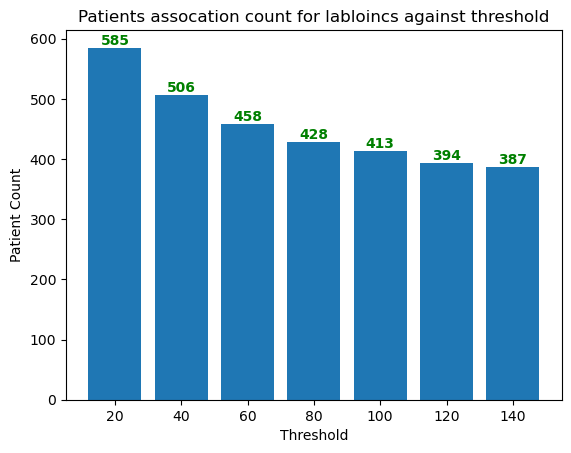

In [55]:
bplot = plt.bar(list(map(str, threshold)) , patients_association_count)
plt.bar_label(bplot,
              fontweight='bold',
              color='green')
plt.title('Patients assocation count for labloincs against threshold')
plt.xlabel('Threshold')
plt.ylabel('Patient Count')
plt.show()

In [56]:
### finding columns to ignore
selected_threshold =50
keep_columns = []
for i,j in labresults_df.count().to_dict(as_series=False).items():
        if i!='PATIENT_NUM' and j[0]>selected_threshold:
            keep_columns.append(i)

In [57]:
print("Number of columns to be kept with threshold {} patients: {}".format(selected_threshold, len(keep_columns)))

Number of columns to be kept with threshold 50 patients: 479


In [58]:
len(keep_columns)

479

In [59]:
labresults_pivot_keep_df = labresults_df.select(['PATIENT_NUM'] + keep_columns)

In [60]:
labresults_pivot_keep_df.filter(pl.all_horizontal(pl.all().exclude('PATIENT_NUM').is_null()))

PATIENT_NUM,LOINC:2500-7,LOINC:5818-0,LOINC:2571-8,LOINC:2345-7,LOINC:73578-7,LOINC:3016-3,LOINC:706-2,LOINC:2885-2,LOINC:777-3,LOINC:1975-2,LOINC:785-6,LOINC:6768-6,LOINC:1742-6,LOINC:11054-4,LOINC:1920-8,LOINC:5905-5,LOINC:51584-1,LOINC:736-9,LOINC:787-2,LOINC:770-8,LOINC:788-0,LOINC:2028-9,LOINC:13457-7,LOINC:17861-6,LOINC:3097-3,LOINC:2862-1,LOINC:2075-0,LOINC:11580-8,LOINC:2823-3,LOINC:10834-0,LOINC:1759-0,LOINC:28542-9,LOINC:48642-3,LOINC:13658-0,LOINC:3094-0,LOINC:718-7,…,LOINC:17811-1,LOINC:17817-8,LOINC:2149-3,LOINC:48378-4,LOINC:4547-6,LOINC:32350-1,LOINC:35707-9,LOINC:32123-2,LOINC:20466-9,LOINC:30572-2,LOINC:4575-7,LOINC:38445-3,LOINC:19049-6,LOINC:15016-9,LOINC:2472-9,LOINC:32046-5,LOINC:28541-1,LOINC:26505-8,LOINC:41649-5,LOINC:32682-7,LOINC:30433-7,LOINC:2147-7,LOINC:20568-2,LOINC:32353-5,LOINC:2148-5,LOINC:6942-7,LOINC:2609-6,LOINC:13981-6,LOINC:48343-8,LOINC:29142-7,LOINC:17782-4,LOINC:2669-0,LOINC:72888-1,LOINC:33944-0,LOINC:42246-9,LOINC:2095-8,LOINC:38506-2
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
2955018,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
6177437,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5932797,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2210945,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3167382,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
647189,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1213370,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,n

In [61]:
print("Number of patients lost after reducing the patients count: ",len(labresults_pivot_keep_df.filter(pl.all_horizontal(pl.all().exclude('PATIENT_NUM').is_null()))))

Number of patients lost after reducing the patients count:  80


In [62]:
labresults_pivot_keep_df = labresults_pivot_keep_df.filter(~pl.all_horizontal(pl.all().exclude('PATIENT_NUM').is_null()))

In [63]:
labresults_pivot_keep_df = labresults_pivot_keep_df.fill_null(-100)

In [64]:
len(labresults_pivot_keep_df)

406193

In [65]:
if 'all' in modeling_config.labs_path:
    labresults_pivot_keep_df.write_parquet('./Determine_modeling_datasets/Determine_modeling_labresults_median_all_features_thrs_'+str(selected_threshold)+'.parquet')
if 'domain_expert' in modeling_config.labs_path:
    labresults_pivot_keep_df.write_parquet('./Determine_modeling_datasets/Determine_modeling_labresults_median_domain_expert_thrs_'+str(selected_threshold)+'.parquet')

## Medications

In [23]:
medications_pivot_df = pl.read_parquet(modeling_config.folder+modeling_config.meds_path)

In [24]:
print("Number of data points: ",len(medications_pivot_df))

Number of data points:  531679


In [25]:
medications_pivot_df.head(3)

PATIENT_NUM,phenazopyridine,nitrofurantoin,amlodipine,lisinopril_hydrochlorothiazide,cephalexin,albuterol,nystatin,metronidazole,varicella-zoster virus vaccine live (Oka-Merck) strain,mometasone_formoterol,chlorthalidone,potassium chloride,ketorolac,azithromycin,triamcinolone,acetaminophen_hydrocodone,gabapentin,tramadol,capsaicin,ibuprofen,naproxen,codeine_promethazine,omeprazole,clotrimazole,lorazepam,fluticasone,cholecalciferol,calcium carbonate,paroxetine,loratadine,aluminum chloride,penicillin G,sulfamethoxazole_trimethoprim,ondansetron,doxylamine_pyridoxine,folic acid,…,chlorpheniramine_codeine_pseudoephedrine,nabilone,zinc acetate,vitamin B12_ascorbic acid_iron carbonyl_folic acid_docusate,thioguanine,carbinoxamine,ketamine,rx_cui:1303740,ammonia,tyrosine,sodium phosphate,rx_cui:1150087,factor VIII,ethanol,fingolimod,rx_cui:1247404,icatibant,rx_cui:1356525,polysaccharide iron complex_vitamin B12_folic acid_heme iron polypeptide,rx_cui:856892,rx_cui:313409,"poliovirus vaccine inactivated, type 1 (Mahoney)_poliovirus vaccine inactivated, type 2 (MEF-1)_poliovirus vaccine inactivated, type 3 (Saukett)_acellular pertussis vaccine, inactivated_diphtheria toxoid vaccine, inactivated_tetanus toxoid vaccine, inactivated",rx_cui:198725,rx_cui:1249797,rx_cui:966545,dexbrompheniramine_pseudoephedrine,benzethonium_benzocaine,rx_cui:237778,rx_cui:2174531,rx_cui:204969,rx_cui:310468,ganirelix,follicle stimulating hormone_luteinizing hormone,aztreonam,isoniazid_rifampin,lactate_calcium chloride_glucose_potassium chloride_sodium chloride,glucose_potassium chloride_sodium chloride
i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
556,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
560,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
561,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
medications_pivot_df.sum()

PATIENT_NUM,phenazopyridine,nitrofurantoin,amlodipine,lisinopril_hydrochlorothiazide,cephalexin,albuterol,nystatin,metronidazole,varicella-zoster virus vaccine live (Oka-Merck) strain,mometasone_formoterol,chlorthalidone,potassium chloride,ketorolac,azithromycin,triamcinolone,acetaminophen_hydrocodone,gabapentin,tramadol,capsaicin,ibuprofen,naproxen,codeine_promethazine,omeprazole,clotrimazole,lorazepam,fluticasone,cholecalciferol,calcium carbonate,paroxetine,loratadine,aluminum chloride,penicillin G,sulfamethoxazole_trimethoprim,ondansetron,doxylamine_pyridoxine,folic acid,…,chlorpheniramine_codeine_pseudoephedrine,nabilone,zinc acetate,vitamin B12_ascorbic acid_iron carbonyl_folic acid_docusate,thioguanine,carbinoxamine,ketamine,rx_cui:1303740,ammonia,tyrosine,sodium phosphate,rx_cui:1150087,factor VIII,ethanol,fingolimod,rx_cui:1247404,icatibant,rx_cui:1356525,polysaccharide iron complex_vitamin B12_folic acid_heme iron polypeptide,rx_cui:856892,rx_cui:313409,"poliovirus vaccine inactivated, type 1 (Mahoney)_poliovirus vaccine inactivated, type 2 (MEF-1)_poliovirus vaccine inactivated, type 3 (Saukett)_acellular pertussis vaccine, inactivated_diphtheria toxoid vaccine, inactivated_tetanus toxoid vaccine, inactivated",rx_cui:198725,rx_cui:1249797,rx_cui:966545,dexbrompheniramine_pseudoephedrine,benzethonium_benzocaine,rx_cui:237778,rx_cui:2174531,rx_cui:204969,rx_cui:310468,ganirelix,follicle stimulating hormone_luteinizing hormone,aztreonam,isoniazid_rifampin,lactate_calcium chloride_glucose_potassium chloride_sodium chloride,glucose_potassium chloride_sodium chloride
i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
1834894773716,5383,14316,30033,9866,14666,63642,5360,31716,1290,1624,2848,6620,10965,45614,28234,27326,30206,14472,3368,80940,39787,2299,50710,15115,11498,42976,29181,3247,6745,30917,433,3737,22273,15285,524,19856,…,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [27]:
threshold  = [10,20,40,60,80,200]
patients_association_count  =[]
for thr in threshold:
    patients_association_count.append(get_association_count(medications_pivot_df, thr,use_func = 'sum'))

In [28]:
patients_association_count

[938, 835, 727, 654, 605, 472]

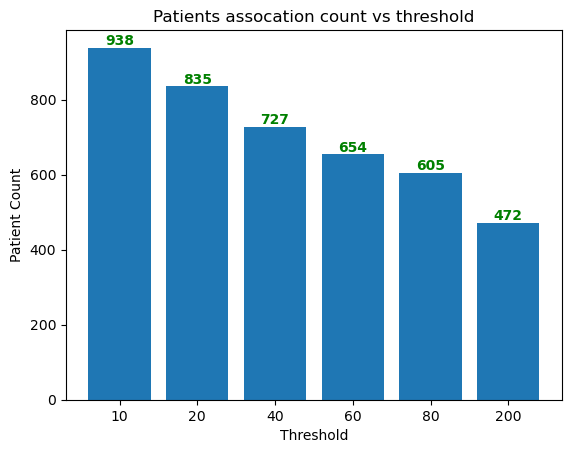

In [29]:
get_patients_association_threshold_bar_plot(threshold,patients_association_count)

In [30]:
### finding columns to ignore
selected_threshold =50
keep_columns = []
for i,j in medications_pivot_df.sum().to_dict(as_series=False).items():
        if i!='PATIENT_NUM' and j[0]>selected_threshold:
            keep_columns.append(i)

In [31]:
print("Number of columns to be kept with threshold {} patients: {}".format(selected_threshold, len(keep_columns)))

Number of columns to be kept with threshold 50 patients: 691


In [32]:
medications_pivot_keep_df = medications_pivot_df.select(['PATIENT_NUM'] + keep_columns)

In [33]:
print("Number of patients lost after reducing the patients count: ",len(medications_pivot_keep_df.filter(pl.all_horizontal(pl.all().exclude('PATIENT_NUM').eq(0)))))

Number of patients lost after reducing the patients count:  369


In [34]:
medications_pivot_keep_df = medications_pivot_keep_df.filter(~pl.all_horizontal(pl.all().exclude('PATIENT_NUM').eq(0)))

In [35]:
len(medications_pivot_keep_df)

531310

In [36]:
medications_pivot_keep_df.write_parquet('./Determine_modeling_datasets/Determine_modeling_medications_thrs_'+str(selected_threshold)+'.parquet')

## Diagnoses

In [84]:
diag_pivot_df = pl.read_parquet(modeling_config.folder+modeling_config.diag_path)

In [85]:
print("Number of data points: ",len(diag_pivot_df))

Number of data points:  751830


In [86]:
diag_pivot_df.head()

PATIENT_NUM,I10,K25,L82,M19,N28,N30,R30,R63,Z01,Z12,Z13,Z23,E78,Z86,J45,E87,Z00,Z20,R29,R25,M79,L25,I87,H53,Z72,R76,R03,M54,M51,M25,M17,L30,J40,J06,G89,N92,…,A99,V78,J17,S08,V68,U07,V40,N51,E40,Y82,J82,P39,G94,D74,T64,E45,A22,Y79,H82,V25,P78,V34,X93,X94,B43,V61,V62,V60,V69,V16,D19,M49,Y38,Y62,84.,D78,A94
i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
556,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
560,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
562,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
564,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
574,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
threshold  = [10,20,40,60,80,200]
patients_association_count  =[]
for thr in threshold:
    patients_association_count.append(get_association_count(diag_pivot_df, thr,use_func = 'sum'))

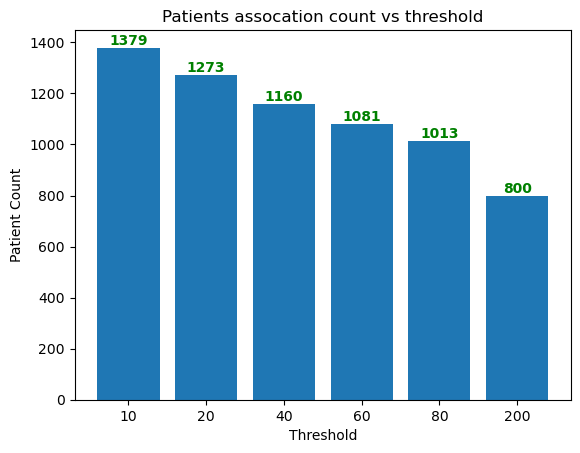

In [88]:
get_patients_association_threshold_bar_plot(threshold,patients_association_count)

In [89]:
### finding columns to ignore
selected_threshold =50
keep_columns = []
for i,j in diag_pivot_df.sum().to_dict(as_series=False).items():
        if i!='PATIENT_NUM' and j[0]>selected_threshold:
            keep_columns.append(i)

In [90]:
print("Number of columns to be kept with threshold {} patients: {}".format(selected_threshold, len(keep_columns)))

Number of columns to be kept with threshold 50 patients: 1119


In [91]:
diag_pivot_keep_df = diag_pivot_df.select(['PATIENT_NUM'] + keep_columns)

In [92]:
print("Number of patients lost after reducing the patients count: ",len(diag_pivot_keep_df.filter(pl.all_horizontal(pl.all().exclude('PATIENT_NUM').eq(0)))))

Number of patients lost after reducing the patients count:  153


In [93]:
diag_pivot_keep_df = diag_pivot_keep_df.filter(~pl.all_horizontal(pl.all().exclude('PATIENT_NUM').eq(0)))

In [94]:
if 'phemap' in modeling_config.diag_path:
    prefix = 'phemap'
else:
    prefix = 'initial_3_chars'

if 'without' in modeling_config.diag_path:
    diag_pivot_keep_df.write_parquet(f'./Determine_modeling_datasets/Determine_modeling_diagnoses_{prefix}_thrs_'+str(selected_threshold)+'_without_icd10z'+'.parquet')
else:
    diag_pivot_keep_df.write_parquet(f'./Determine_modeling_datasets/Determine_modeling_diagnoses_{prefix}_thrs_'+str(selected_threshold)+'_with_icd10z'+'.parquet')

## Target

In [95]:
label_df =pl.read_parquet(modeling_config.target_path)

In [96]:
label_df.head()

PATIENT_NUM,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD
i64,datetime[μs],datetime[μs],i64,i64,datetime[μs],str
8202921,2017-03-15 00:00:00,2019-05-29 00:00:00,60,1,null,"""83706"""
6046573,2017-03-27 00:00:00,null,45,0,null,"""97136"""
2179286,2016-12-13 00:00:00,null,34,0,null,"""77530"""
6861988,2016-09-16 00:00:00,null,33,0,null,"""90035"""
7452088,2017-02-02 00:00:00,null,43,0,null,"""75217"""


In [97]:
np.unique(label_df['Outcome'].to_list(), return_counts = True)

(array([0, 1]), array([1004264,   60204]))

In [98]:
label_df = label_df.with_columns(pl.col('Age_at_encounter_date').map_elements(lambda x : '18-34' if x <= 34 \
                                                        else '35-44' if 35<=x<=44 else '45-54'\
                                                        if 45<=x<=54 else '55-64' if 55<=x<=64 else \
                                                        '65-74' if  65<=x<=74 else '75_older').alias('Age_group'))
label_df.head()

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


PATIENT_NUM,Index_Start_date,FirstOutcomeDate,Age_at_encounter_date,Outcome,DEATH_DATE,Zip_CD,Age_group
i64,datetime[μs],datetime[μs],i64,i64,datetime[μs],str,str
8202921,2017-03-15 00:00:00,2019-05-29 00:00:00,60,1,null,"""83706""","""55-64"""
6046573,2017-03-27 00:00:00,null,45,0,null,"""97136""","""45-54"""
2179286,2016-12-13 00:00:00,null,34,0,null,"""77530""","""18-34"""
6861988,2016-09-16 00:00:00,null,33,0,null,"""90035""","""18-34"""
7452088,2017-02-02 00:00:00,null,43,0,null,"""75217""","""35-44"""


In [99]:
label_df.select(['PATIENT_NUM','Age_group','FirstOutcomeDate','Outcome']).write_parquet('./Determine_modeling_datasets/Determine_modeling_age_group_outcome_data.parquet')

## Demographics

In [100]:
demo_df = pl.read_parquet('./Determine_cohort_files/'+modeling_config.demo_path)

In [101]:
demo_df.head()

Patient_num,Sex_CD,Race_CD,Hispanic_CD,Gender_CD
i64,str,str,str,str
114343,"""M""","""05""","""N""","""M"""
114406,"""F""","""UN""","""Y""","""W"""
114410,"""F""","""05""","""N""","""W"""
114413,"""M""","""05""","""Y""","""UN"""
114440,"""M""","""05""","""N""","""UN"""


In [102]:
np.unique(demo_df['Gender_CD'].to_list())

array(['GQ', 'M', 'OT', 'TG', 'UN', 'W'], dtype='<U2')

In [103]:
demo_df.write_parquet("./Determine_modeling_datasets/Determine_modeling_demographics_data.parquet")